### Look at how sea ice advance and retreat timing affects biology

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

import utils

### Get the CESM2 4p4z tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 6.96 s, sys: 431 ms, total: 7.39 s
Wall time: 10.5 s


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude to the same length as polynas and fix time

In [5]:
ds = ds.isel(nlat=slice(0,76))

In [6]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Get coords

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)
xlen=len(ds.nlon)
ylen=len(ds.nlat)

### Make the biological variables 2-D

In [8]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['big_zooC_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']
ds['sm_zooC_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint']

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

Drop the 3-D vars now

In [9]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['dz','z_t','z_t_150m'])

In [10]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### remove last year of data from ds

In [12]:
ds = ds.isel(time=slice(0,720))

In [13]:
tlen = len(ds.time)

## make annual data

In [14]:
%%time
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 56s, sys: 31.7 s, total: 3min 28s
Wall time: 3min 19s


### Get sea ice advance /retreat files

Days are Julian days (1-365 although higher allowed for retreat in SH - see below)

Day of advance: first day of ice-year that ice concentration in a grid cell exceeds 15% and remains above 15% for at least 5 days

Day of retreat: first day after ice advance that ice concentration falls below 15% and remains so for remainder of ice-year

Ice year in Southern Hemisphere is defined as Feb 15 yr1 to Feb 14 yr2.

Ice retreat day will tend to be large - and in some cases will actually be >365 as it might fall in Jan or early Feb of following year.


#### get data from laura's files

In [16]:
path = '/glade/p/cesm/pcwg/landrum/'

file = path + case + '/ice/analysis/daily/RetreatAdvance/' + case + '.RetreatAdvance_sh.aice_d.0062-0121.nc'

ds_seaice = xr.open_dataset(file, decode_times=True)


### make some adjustment so the two datasets align

• rename coords from seaice ds

• overwrite 'time' dimension in the seaice data

In [17]:
ds_seaice = ds_seaice.rename({'ni': 'nlon','nj': 'nlat','year':'time'})

In [18]:
ds_seaice['time'] = ds_ann.time

### DATA IS PREPPED

Where do ice metrics vary the most?

In [20]:
st_dev_ndays = ds_seaice.ice_ndays.std(dim='time')
st_dev_duration = ds_seaice.ice_duration.std(dim='time')
st_dev_retreat = ds_seaice.ice_retreat.std(dim='time')
st_dev_advance = ds_seaice.ice_advance.std(dim='time')

In [21]:
mean_ndays = ds_seaice.ice_ndays.mean(dim='time')
mean_duration = ds_seaice.ice_duration.mean(dim='time')
mean_retreat = ds_seaice.ice_retreat.mean(dim='time')
mean_advance = ds_seaice.ice_advance.mean(dim='time')

In [22]:
coeffvar_ndays = st_dev_ndays/mean_ndays
coeffvar_duration = st_dev_duration/mean_duration
coeffvar_retreat = st_dev_retreat/mean_retreat
coeffvar_advance = st_dev_advance/mean_advance

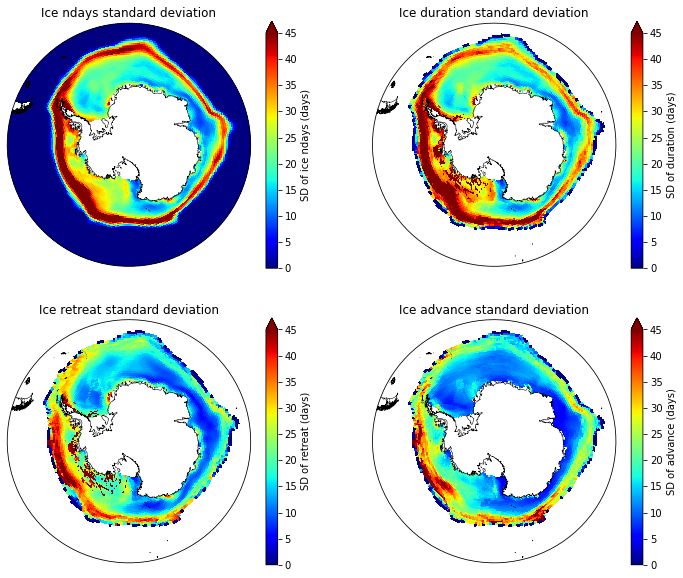

In [31]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, st_dev_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of ice ndays (days)')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, st_dev_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of duration (days)')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, st_dev_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of retreat (days)')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance standard deviation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, st_dev_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=45, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='SD of advance (days)')

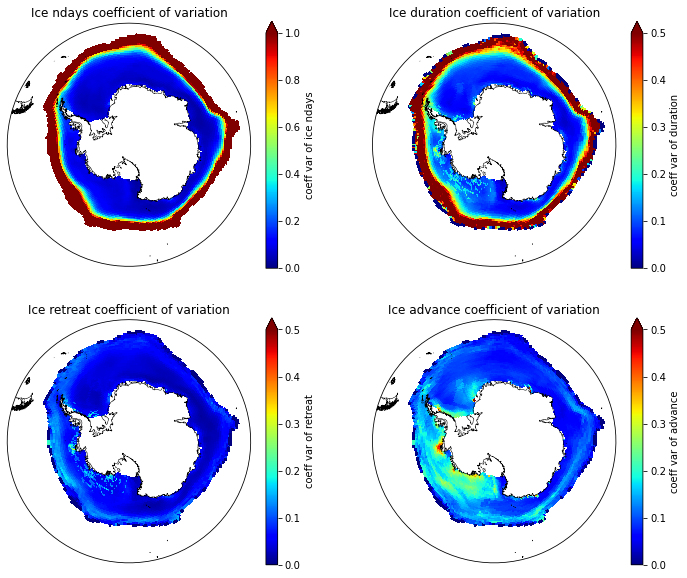

In [32]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, coeffvar_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of ice ndays')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, coeffvar_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of duration')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, coeffvar_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of retreat')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance coefficient of variation')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, coeffvar_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coeff var of advance')

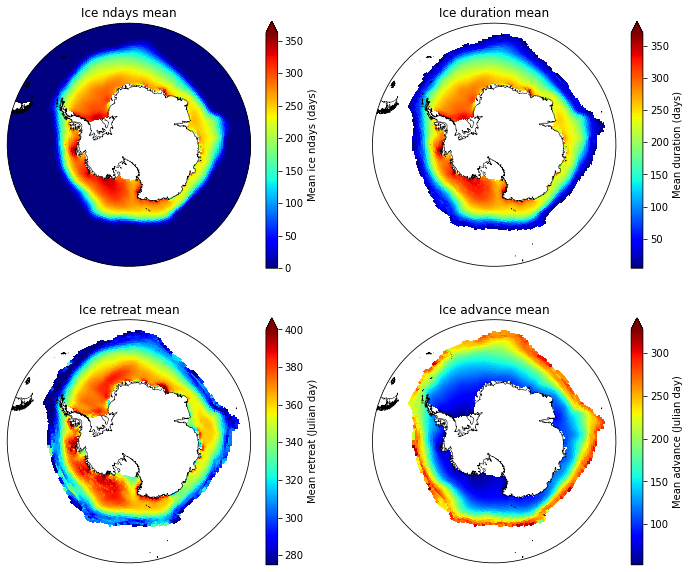

In [33]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, mean_ndays)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean ice ndays (days)')
###########################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, mean_duration)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean duration (days)')

###########################
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, mean_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=275, vmax=400, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean retreat (Julian day)')

###########################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance mean')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats, mean_advance)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean advance (Julian day)')

### Look at areas around the sea ice edge with early retreat (mean sea ice retreat < 290)

In [34]:
early_retreat_ds = ds.where(mean_retreat < 290)

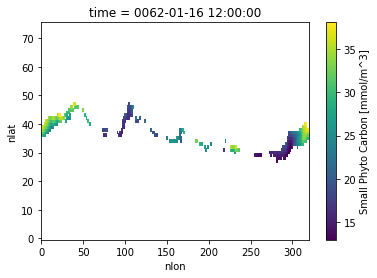

In [35]:
early_retreat_ds.spC_zint.isel(time=0).plot()

In [36]:
early_retreat_mon_clim = early_retreat_ds.groupby('time.month').mean('time')

### Look at areas with late sea ice retreat

In [37]:
late_retreat_ds = ds.where(mean_retreat > 350)

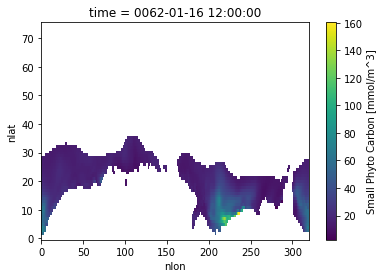

In [38]:
late_retreat_ds.spC_zint.isel(time=0).plot()

In [39]:
late_retreat_mon_clim = late_retreat_ds.groupby('time.month').mean('time')

In [40]:
late_retreat_mon_clim = xr.concat([late_retreat_mon_clim,late_retreat_mon_clim.isel(month=slice(0,6))],dim='month')
early_retreat_mon_clim = xr.concat([early_retreat_mon_clim,early_retreat_mon_clim.isel(month=slice(0,6))],dim='month')

In [41]:
variables = ['spC_zint','diatC_zint', 'sm_zooC_zint','big_zooC_zint']

### make area weighted averages

In [42]:
%%time
ts_early_retreat = xr.Dataset({v: early_retreat_mon_clim[v] for v in ['month']})
ts_late_retreat = xr.Dataset({v: late_retreat_mon_clim[v] for v in ['month']})


for var in variables:
    
    print('doing var ',var)
    
    ts_early_retreat[var] = esmlab.weighted_mean(early_retreat_mon_clim[var], weights=area, dim=['nlat', 'nlon']).compute()
    ts_late_retreat[var] = esmlab.weighted_mean(late_retreat_mon_clim[var], weights=area, dim=['nlat', 'nlon']).compute()


doing var  spC_zint
doing var  diatC_zint
doing var  sm_zooC_zint
doing var  big_zooC_zint
CPU times: user 4min 28s, sys: 19.4 s, total: 4min 48s
Wall time: 5min 1s


In [43]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

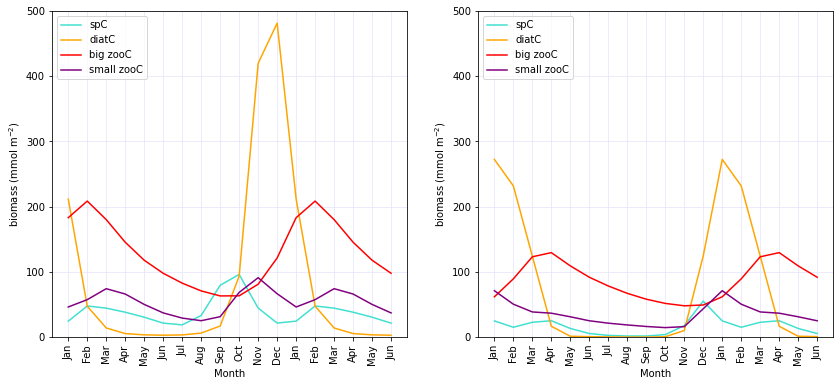

In [44]:
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.set_ylim(0,500)
#plot spC
ax1.plot(xvals,ts_early_retreat.spC_zint, 
         color='turquoise', label='spC')

#plot diatC
ax1.plot(xvals,ts_early_retreat['diatC_zint'], 
         color='orange', label='diatC')

#plot big zoo
ax1.plot(xvals,ts_early_retreat['big_zooC_zint'], 
         color='red', label='big zooC')

#plot sm zoo
ax1.plot(xvals,ts_early_retreat['sm_zooC_zint'], 
         color='purple', label='small zooC')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');


ax1 = fig.add_subplot(1,2,2)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.set_ylim(0,500)
#plot spC
ax1.plot(xvals,ts_late_retreat.spC_zint, 
         color='turquoise', label='spC')

#plot diatC
ax1.plot(xvals,ts_late_retreat['diatC_zint'], 
         color='orange', label='diatC')

#plot big zoo
ax1.plot(xvals,ts_late_retreat['big_zooC_zint'], 
         color='red', label='big zooC')

#plot sm zoo
ax1.plot(xvals,ts_late_retreat['sm_zooC_zint'], 
         color='purple', label='small zooC')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');


## But what about looking at the seasonal cycle in the same place on early versus late retreat years?

#### Create arrays for advance retreat with yearly data but with a monthly time dimension so it can be used as a mask for the biological variables

In [45]:
monthly_advance = np.full((tlen,ylen,xlen),1,dtype=int)
monthly_retreat = np.full((tlen,ylen,xlen),1,dtype=int)

In [46]:
for year in np.arange(0,60,1):
    #print(year)
    lower_month_bnd = year * 12
    upper_month_bnd = lower_month_bnd + 12
    
    for month in np.arange(lower_month_bnd,upper_month_bnd,1):
    
        monthly_advance[month,:,:] = ds_seaice.ice_advance.isel(time=year)
        monthly_retreat[month,:,:] = ds_seaice.ice_retreat.isel(time=year).values

In [47]:
monthly_advance = xr.DataArray(monthly_advance, dims=('time','nlat','nlon'))
monthly_advance = monthly_advance.where(monthly_advance > 0)

monthly_retreat = xr.DataArray(monthly_retreat, dims=('time','nlat','nlon'))
monthly_retreat = monthly_retreat.where(monthly_retreat > 0)

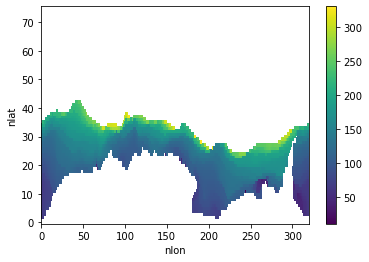

In [48]:
monthly_advance.isel(time=719).plot()

### Early retreat  = mean retreat day - 1${\sigma}$

### Late retreat = mean retreat day + 1${\sigma}$

In [49]:
## early defined as mean retreat minus one st dev
early_retreat_mask = xr.DataArray(np.full((tlen,ylen,xlen),1,dtype=int), dims=('time','nlat','nlon'))
early_retreat_mask = early_retreat_mask.where(monthly_retreat < (mean_retreat - st_dev_retreat))

In [50]:
## late defined as mean retreat plus one st dev
late_retreat_mask = xr.DataArray(np.full((tlen,ylen,xlen),1,dtype=int), dims=('time','nlat','nlon'))
late_retreat_mask = late_retreat_mask.where(monthly_retreat > (mean_retreat + st_dev_retreat))

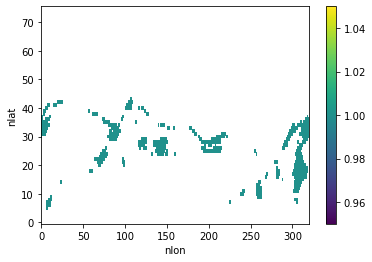

In [51]:
early_retreat_mask.isel(time=52).plot()

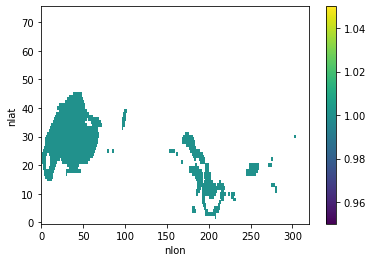

In [52]:
late_retreat_mask.isel(time=52).plot()

In [53]:
early_retreat_ds = ds.where(early_retreat_mask == 1)
late_retreat_ds = ds.where(late_retreat_mask == 1)

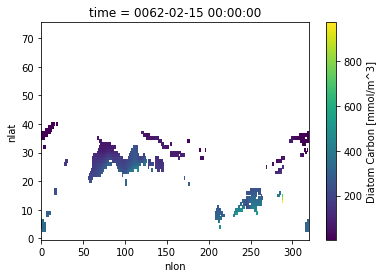

In [54]:
early_retreat_ds.diatC_zint.isel(time=1).plot()

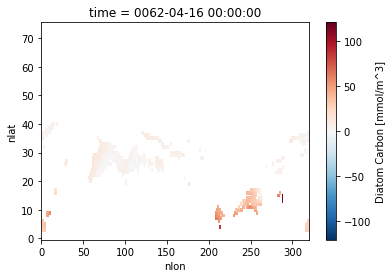

In [55]:
early_retreat_ds.diatC_zint.isel(time=3).plot()

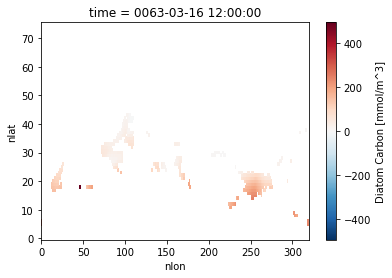

In [56]:
early_retreat_ds.diatC_zint.isel(time=14).plot()

### Make monthly climatologies for early retreat years versus late retreat years

In [57]:
early_retreat_mon_clim = early_retreat_ds.groupby('time.month').mean('time')
late_retreat_mon_clim = late_retreat_ds.groupby('time.month').mean('time')

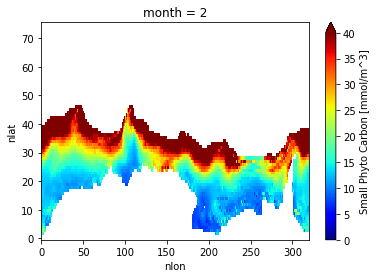

In [58]:
early_retreat_mon_clim.spC_zint.isel(month=1).plot(vmin=0,vmax=40,cmap='jet')

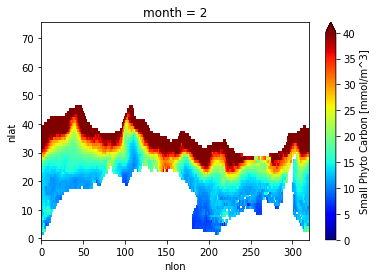

In [59]:
late_retreat_mon_clim.spC_zint.isel(month=1).plot(vmin=0,vmax=40,cmap='jet')

### make mean monthly climatologies for certain regions

In [60]:
############ Ross Sea area
ross_latmin = -76
ross_latmax = -69
ross_lonmin = -180
ross_lonmax = -160

########### Amery Ice shelf area
amery_latmin = -70
amery_latmax = -62
amery_lonmin = 60
amery_lonmax = 80.

In [61]:
lons_norm = utils.normal_lons(lons)

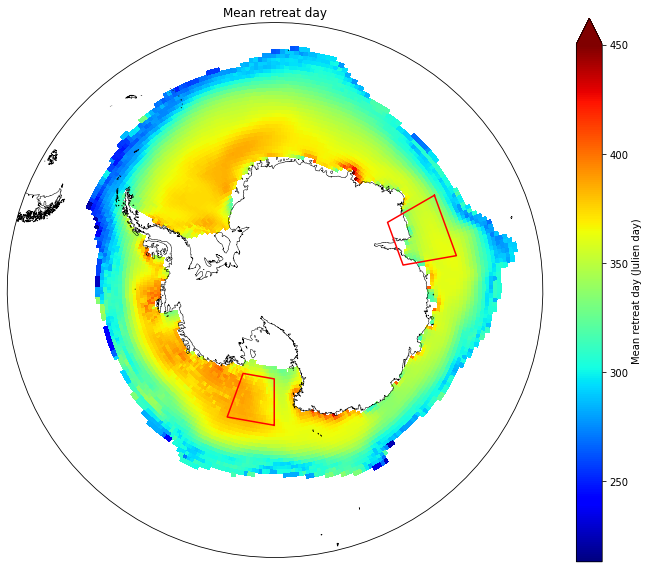

In [62]:
fig = plt.figure(figsize=(12,10))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Mean retreat day')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, mean_retreat)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 #vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


# boxes
lon_pts = [ross_lonmin,ross_lonmax,ross_lonmax,ross_lonmin,ross_lonmin]
lat_pts = [ross_latmax,ross_latmax,ross_latmin,ross_latmin,ross_latmax]
ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree())

# boxes
lon_pts = [amery_lonmin,amery_lonmax,amery_lonmax,amery_lonmin,amery_lonmin]
lat_pts = [amery_latmax,amery_latmax,amery_latmin,amery_latmin,amery_latmax]
ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mean retreat day (Julien day)')

In [63]:
variables

['spC_zint', 'diatC_zint', 'sm_zooC_zint', 'big_zooC_zint']

## Make timeseries of monthly climatologies in boxes

In [64]:
%%time
ts_ross_box_early_rt = xr.Dataset({v: early_retreat_mon_clim[v] for v in ['month']})

for v in variables:
    masked = early_retreat_mon_clim[v].where(lats<ross_latmax).where(lats>ross_latmin).where(lons_norm<ross_lonmax).where(lons_norm>ross_lonmin)
    ts_ross_box_early_rt[v] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_ross_box_early_rt = xr.concat([ts_ross_box_early_rt,ts_ross_box_early_rt.isel(month=slice(0,6))],dim='month')

CPU times: user 2min 14s, sys: 9.55 s, total: 2min 23s
Wall time: 2min 18s


In [65]:
%%time
ts_ross_box_late_rt = xr.Dataset({v: late_retreat_mon_clim[v] for v in ['month']})

for v in variables:
    masked = late_retreat_mon_clim[v].where(lats<ross_latmax).where(lats>ross_latmin).where(lons_norm<ross_lonmax).where(lons_norm>ross_lonmin)
    ts_ross_box_late_rt[v] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_ross_box_late_rt = xr.concat([ts_ross_box_late_rt,ts_ross_box_late_rt.isel(month=slice(0,6))],dim='month')

CPU times: user 2min 14s, sys: 9.7 s, total: 2min 23s
Wall time: 2min 18s


In [66]:
%%time
ts_amery_box_early_rt = xr.Dataset({v: early_retreat_mon_clim[v] for v in ['month']})

for v in variables:
    masked = early_retreat_mon_clim[v].where(lats<amery_latmax).where(lats>amery_latmin).where(lons_norm<amery_lonmax).where(lons_norm>amery_lonmin)
    ts_amery_box_early_rt[v] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_amery_box_early_rt = xr.concat([ts_amery_box_early_rt,ts_amery_box_early_rt.isel(month=slice(0,6))],dim='month')

CPU times: user 2min 14s, sys: 9.74 s, total: 2min 23s
Wall time: 2min 18s


In [67]:
%%time
ts_amery_box_late_rt = xr.Dataset({v: late_retreat_mon_clim[v] for v in ['month']})

for v in variables:
    masked = late_retreat_mon_clim[v].where(lats<amery_latmax).where(lats>amery_latmin).where(lons_norm<amery_lonmax).where(lons_norm>amery_lonmin)
    ts_amery_box_late_rt[v] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_amery_box_late_rt = xr.concat([ts_amery_box_late_rt,ts_amery_box_late_rt.isel(month=slice(0,6))],dim='month')

CPU times: user 2min 14s, sys: 9.61 s, total: 2min 24s
Wall time: 2min 19s


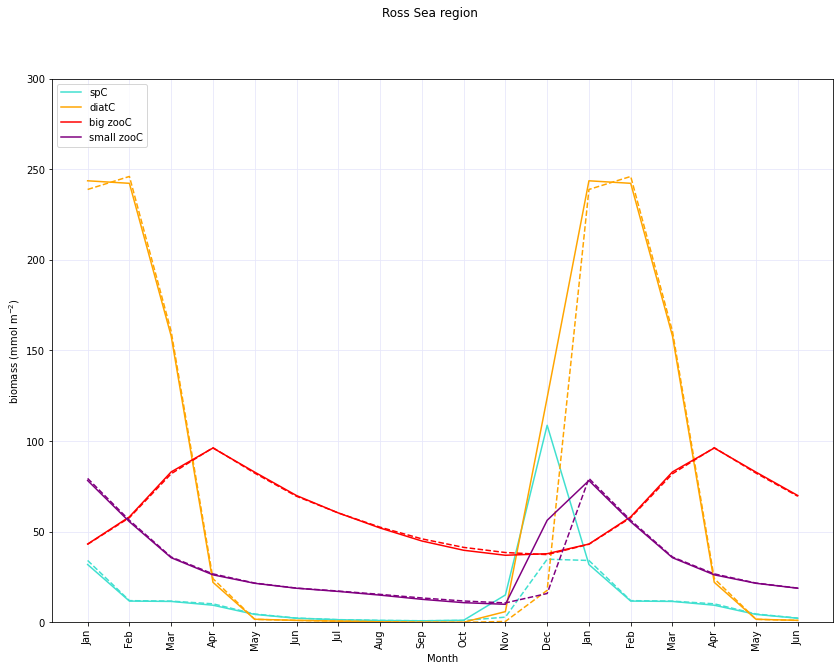

In [68]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Ross Sea region')

ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.set_ylim(0,300)
#plot spC
ax1.plot(xvals,ts_ross_box_early_rt.spC_zint, 
         color='turquoise', label='spC')
ax1.plot(xvals,ts_ross_box_late_rt.spC_zint, 
         color='turquoise',linestyle='--')

#plot diatC
ax1.plot(xvals,ts_ross_box_early_rt['diatC_zint'], 
         color='orange', label='diatC')
ax1.plot(xvals,ts_ross_box_late_rt['diatC_zint'], 
         color='orange', linestyle='--')

#plot big zoo
ax1.plot(xvals,ts_ross_box_early_rt['big_zooC_zint'], 
         color='red', label='big zooC')
ax1.plot(xvals,ts_ross_box_late_rt['big_zooC_zint'], 
         color='red', linestyle='--')
#plot sm zoo
ax1.plot(xvals,ts_ross_box_early_rt['sm_zooC_zint'], 
         color='purple', label='small zooC')
ax1.plot(xvals,ts_ross_box_late_rt['sm_zooC_zint'], 
         color='purple', linestyle='--')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');

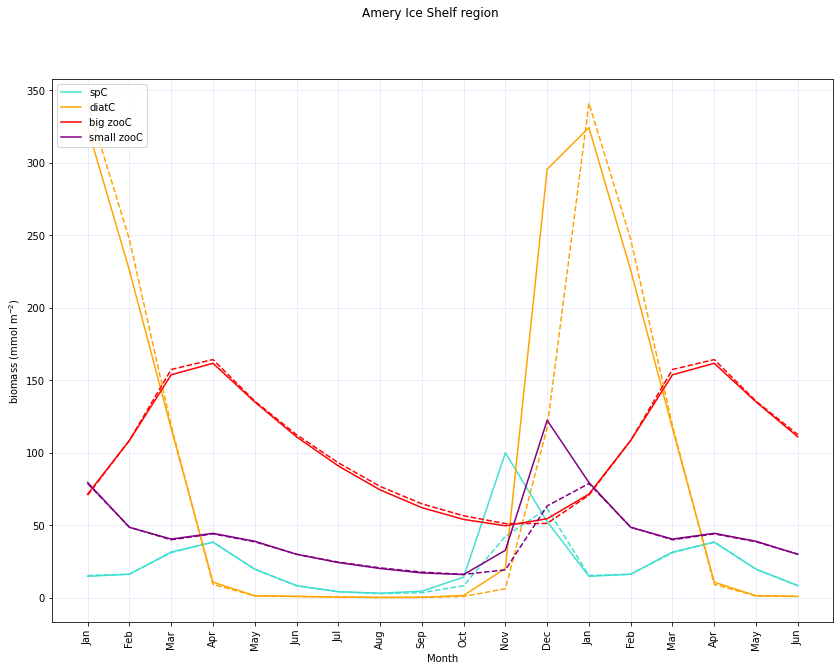

In [69]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Amery Ice Shelf region')

ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('biomass (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#ax1.set_ylim(0,300)
#plot spC
ax1.plot(xvals,ts_amery_box_early_rt.spC_zint, 
         color='turquoise', label='spC')
ax1.plot(xvals,ts_amery_box_late_rt.spC_zint, 
         color='turquoise',linestyle='--')

#plot diatC
ax1.plot(xvals,ts_amery_box_early_rt['diatC_zint'], 
         color='orange', label='diatC')
ax1.plot(xvals,ts_amery_box_late_rt['diatC_zint'], 
         color='orange', linestyle='--')

#plot big zoo
ax1.plot(xvals,ts_amery_box_early_rt['big_zooC_zint'], 
         color='red', label='big zooC')
ax1.plot(xvals,ts_amery_box_late_rt['big_zooC_zint'], 
         color='red', linestyle='--')
#plot sm zoo
ax1.plot(xvals,ts_amery_box_early_rt['sm_zooC_zint'], 
         color='purple', label='small zooC')
ax1.plot(xvals,ts_amery_box_late_rt['sm_zooC_zint'], 
         color='purple', linestyle='--')

ax1.legend(loc='upper left')

plt.xticks(xvals, xlabels, rotation='vertical');